In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

from utils import read_image, color_list
from utils.loading import data_generator

import os

2024-04-11 19:21:03.027015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:21:04.242656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model

Pre-trained VGG16unet model is loaded: trained for 50 epochs at a resolution 224x224. The model is under `models/VGG16unet-224x224-50epochs.model.keras`. If you don't have this model it is publicly availabe at [kaggle](https://www.kaggle.com/models/sergiogarciapajares/vggcloudunet/).

In [2]:
model = tf.keras.models.load_model(os.path.join('models','VGG16unet-224x224-50epochs.model.keras'))

2024-04-11 19:21:06.590190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:21:06.598169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:21:06.598576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Some general constants about image shape are provided by the model itself

In [3]:
IMG_SHAPE = model.input[0].shape[1:] #model.input returns a single element list with the actual input layer
IMG_WIDTH  = IMG_SHAPE[0]
IMG_HEIGHT = IMG_SHAPE[1]
IMG_CHANNELS = IMG_SHAPE[2]

NUM_CLASSES = model.output[0].shape[3] # model.output returns a single element list with the actual output layer

# Test dataset

In [4]:
test_image_names = open(os.path.join('dataset','test.txt')).readlines()
test_dataset = data_generator(
    [os.path.join('dataset','images', name.strip()) for name in test_image_names],
    [os.path.join('dataset','masks', name.strip()) for name in test_image_names],
    batch_size = 2, # test dataset contains 46 images, 46 = 23·2, to include all images 2 must be picked (as 23 is too high)
    num_classes=NUM_CLASSES,
    img_shape=IMG_SHAPE,
)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(2, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(2, 224, 224, 5), dtype=tf.float32, name=None))>


We can predict on out testing dataset. `predictions_prob` contains the one-hot enconded probabilities for each label. `predictions` contains the final predicted label. `ground_truth` contains real labels. 

In [5]:
predictions_prob = model.predict(test_dataset)
predictions = np.argmax(predictions_prob,axis=-1)

I0000 00:00:1712856075.215270  179664 service.cc:145] XLA service 0x762fec0155f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712856075.215328  179664 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-04-11 19:21:15.244873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 19:21:15.568585: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

I0000 00:00:1712856085.152519  179664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step


In [6]:
ground_truth = np.empty_like(predictions)
for index, name in enumerate(test_image_names):
    ground_truth[index,:,:] = read_image( os.path.join('dataset','masks', name.strip()) , IMG_SHAPE )[:,:,0]

# Metrics

## Pixel accuracy

The number of right prediction $\text{Acuracy}=\dfrac{\text{TP}}{\text{Total}}$

In [7]:
np.sum(ground_truth==predictions)/np.prod(ground_truth.shape)


0.9350434297360248

If we do it per label [`N/A`,`sky`,`sun`,`thick`,`thin`]

In [8]:
label_acuracy = np.empty(NUM_CLASSES,dtype=np.float32)
for label in range(NUM_CLASSES):
    label_acuracy[label] = np.sum( (ground_truth == predictions)[ ground_truth == label ])/np.sum( ground_truth == label )

label_acuracy

array([0.9870022 , 0.92362154, 0.47015005, 0.9247548 , 0.00146548],
      dtype=float32)

It's pretty good at finding `N/A`, `sky` and `thick`. But it misses the rest.

## Confusion matrix

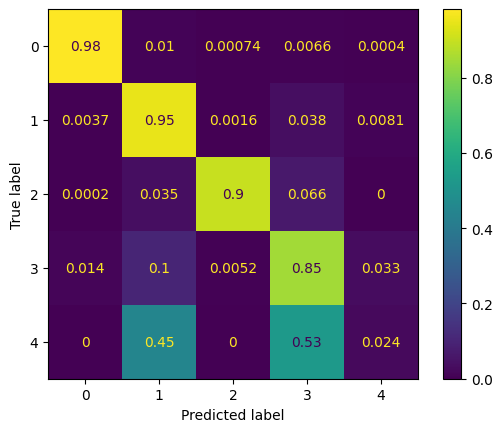

In [9]:
ConfusionMatrixDisplay(
    confusion_matrix(
        predictions.flatten(),
        ground_truth.flatten(),
        labels=np.arange(NUM_CLASSES),
        normalize = 'true',
    )
).plot()

## Precision recall

(0.0, 1.0)

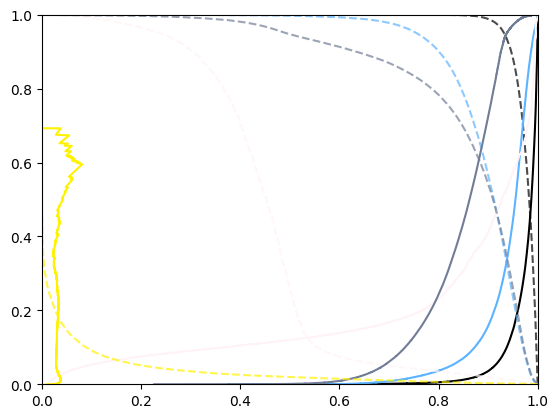

In [10]:
for label in range(NUM_CLASSES):
    precision, recall, threshold = precision_recall_curve(
        ground_truth.flatten(),
        predictions_prob[:,:,:,label].flatten(),
        pos_label=label,
        drop_intermediate=True
    )
    color = rgb2hex(np.array(color_list[label])/255)
    plt.plot(precision[:-1],threshold,'-',color=color,alpha=1)
    plt.plot(recall[:-1],threshold,'--',color=color,alpha=.7)

plt.xlim(0,1)
plt.ylim(0,1)